# Klassifizierer Test

Setup Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pydot
import json
import logging

Erstellt ein Log File in dem alle Runs mit Hyperparametern und Zeit gespeichert werden. Somit geht keine Run verloren.

In [2]:
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)
formatter = logging.Formatter(fmt="%(asctime)s %(levelname)s: %(message)s", 
                          datefmt="%Y-%m-%d - %H:%M:%S")
fh = logging.FileHandler("Classification_Run.log", "a")
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

### Eine JSON Datei mit den Hyperparametern schreiben

In [3]:
# data ist in diesem Fall ein Dictionary
def write_JSON_file(path, file_name, data):
    file_path = './' + path + '/' + file_name + '.json'
    with open(file_path, 'w') as fp:
        json.dump(data, fp)
        

## Auslesen der Daten
Man nimmt die Daten von der RootUrl und slicet alle Labels __(y)__, sodass von jedem Eintrag der erste genommen wird.
Die Daten __(x)__ beinhalten jeden Wert außer den ersten.

Es wird zwischen Train- und Test-Set unterschieden. 

In [4]:
def read_ucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = read_ucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = read_ucr(root_url + "FordA_TEST.tsv")
print(y_train.shape)
x_train.shape

(3601,)


(3601, 500)

## Visualisieren der Daten
Als erstes finden wir heraus, wie viele verschiedene Klassen es gibt, in dem wir die Labels nach einzigartigen Labeln filtern.
Danach Filtern wir die Klassen einzeln und plotten sie auf einen Graphen zusammen.

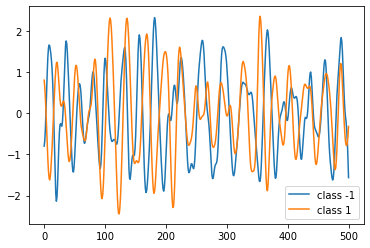

In [5]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standartisieren der Daten
Die Daten sind Z-Normalisiert. Jedes Sample hat einen Mittelwert von 0 und eine Standardabweichung von 1.

Mit einem Reshape verwandeln wir die Univariate Time Series in eine MultiVariate. 

In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Da wir später __sparse_categorical_crossentropy__ benutzen müssen wir die Anzahl der möglichen Klassen kennen

In [7]:
num_classes = len(np.unique(y_train))

Hier werden alle Werte geshufflet als Vorbereitung, um später ein gutes Validation-Set zubekommen

In [8]:
idx = np.random.permutation(len(x_train))

x_train = x_train[idx]
y_train = y_train[idx]

Alle Labels mit dem Wert __-1__ auf __0__ mappen -> keine negativen Ergebnisse

In [9]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Hyperparameter definieren

### Import von Hyperparametern durch JSON

In [10]:
def load_JSON(path):
    with open(path) as json_file:
        daten = json.load(json_file)
        return daten
    
def load_hyperparameter(dictionary, path="./hyperparameter.json"):
    daten = load_JSON(path)
    for key, value in daten.items():
        dictionary[key] = value

Hier werden alle Hyperparameter definiert, sodass man sie leicht ändern kann

In [11]:
hyper_p = {
            "epochs" : 500,

            "batch_size" : 32,

            "filter_size" : 64,

            "kernel_size" : 3,
    
            "activation_function" : "relu",

            "optimizer" : "Adam",
    
            "learning_rate" : 0.001,

            "loss_function" : "sparse_categorical_crossentropy"
            }


callbacks = [
                keras.callbacks.ModelCheckpoint(
                    "best_model.h5", save_best_only=True, monitor="val_loss"
                ),
                keras.callbacks.ReduceLROnPlateau(
                    monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
                ),
                keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
            ]

metrics = ["sparse_categorical_accuracy"]

### Einlesen der Hyperparameter durch JSON
Wenn man eine JSON Datei importieren möchte, kann man diesen Befehl benutzen, der zur Zeit auskommentiert ist. 
Standardmäßig liegt er auf dem Pfad (`./hyperparameter.json`) wo die, aktuell besten, Hyperparameter abgelegt sind. 

Man kann aber einfach einen eigenen Pfad angeben => __load_JSON(dictionary,__ `./eigener/pfad/mit/parameter.json`__)__

Wenn man aus einer zweiten Quelle Parameter lädt wird trotzdem auf der Standardstelle die besten Parameter gespeichert. Somit kann man neue Konfigurationen ausprobieren ohne die besten Konfigurationen zu überschreiben und speichert trotzdem die beste Konfiguration ab.
<br>
<br>
<font color=red>__Achtung! Zur Verwendung bitte den Cell Type von "RawNB" zu "Code" wechseln__<font>

# Normales Modell mit einzelnen Runs (Normal Mode)

## Ein Modell bauen
Wir bauen hier ein dense verbundenes __Convolutional Neural Network__

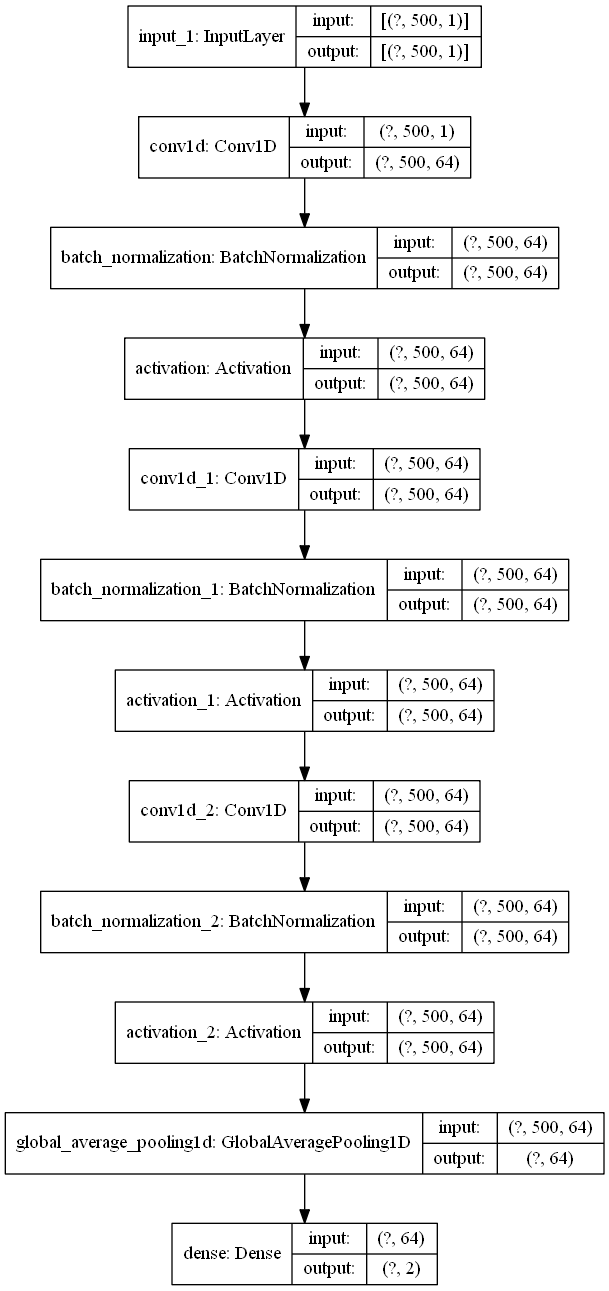

In [12]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    conv1 = keras.layers.Conv1D(filters=hyper_p["filter_size"], kernel_size=hyper_p["kernel_size"], padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation=hyper_p["activation_function"])(conv1)

    conv2 = keras.layers.Conv1D(filters=hyper_p["filter_size"], kernel_size=hyper_p["kernel_size"], padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation(activation=hyper_p["activation_function"])(conv2)

    conv3 = keras.layers.Conv1D(filters=hyper_p["filter_size"], kernel_size=hyper_p["kernel_size"], padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation(activation=hyper_p["activation_function"])(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True) 

## Das Modell trainieren
Hier werden verschiedene Callbacks angegeben
- Das beste Modell speichern
- Die Learing-Rate reduzieren, wenn ein Plateau erreicht wird
- Frühzeitig stoppen, wenn keine Verbesserung mehr Eintritt

In [13]:
# Da man in der JSON nur einen String hat und keine Object, wird hier der folgende String zusammen gesetzt um einen 
# Optimizer zu definieren und die Learning_Rate zu setzen

# Diese Funktion sollte keinen Nutzern verfügbar gemacht werden aufgrund von Code Injection

# Beispiel: opti = keras.optimizers.Adam(learning_rate=0.0001)
str_opti = "opti = keras.optimizers." + hyper_p["optimizer"] + "(learning_rate=" + str(hyper_p["learning_rate"]) + ")"
exec(str_opti)


model.compile(
    optimizer=opti,
    loss=hyper_p["loss_function"],
    metrics=metrics,
)

history = model.fit(
    x_train,
    y_train,
    batch_size=hyper_p["batch_size"],
    epochs=hyper_p["epochs"],
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Train on 2880 samples, validate on 721 samples
Epoch 1/500
2880/2880 [==============================] - 2s 798us/sample - loss: 0.5713 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.7837 - val_sparse_categorical_accuracy: 0.4840
Epoch 2/500
2880/2880 [==============================] - 1s 174us/sample - loss: 0.4703 - sparse_categorical_accuracy: 0.7663 - val_loss: 0.7520 - val_sparse_categorical_accuracy: 0.4840
Epoch 3/500
2880/2880 [==============================] - 1s 177us/sample - loss: 0.4317 - sparse_categorical_accuracy: 0.7872 - val_loss: 0.7078 - val_sparse_categorical_accuracy: 0.5021
Epoch 4/500
2880/2880 [==============================] - 0s 172us/sample - loss: 0.4273 - sparse_categorical_accuracy: 0.7833 - val_loss: 0.5852 - val_sparse_categorical_accuracy: 0.7060
Epoch 5/500
2880/2880 [==============================] - 0s 173us/sample - loss: 0.4127 - sparse_categorical_accuracy: 0.7962 - val_loss: 0.8078 - val_sparse_categorical_accuracy: 0.5312
Epoch 6/500
2880/2

2880/2880 [==============================] - 0s 162us/sample - loss: 0.2484 - sparse_categorical_accuracy: 0.8993 - val_loss: 0.2572 - val_sparse_categorical_accuracy: 0.9015
Epoch 45/500
2880/2880 [==============================] - 0s 169us/sample - loss: 0.2442 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.4088 - val_sparse_categorical_accuracy: 0.8128
Epoch 46/500
2880/2880 [==============================] - 0s 164us/sample - loss: 0.2530 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.2409 - val_sparse_categorical_accuracy: 0.9071
Epoch 47/500
2880/2880 [==============================] - 0s 170us/sample - loss: 0.2429 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.2553 - val_sparse_categorical_accuracy: 0.8793
Epoch 48/500
2880/2880 [==============================] - 0s 162us/sample - loss: 0.2381 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.7002 - val_sparse_categorical_accuracy: 0.6893
Epoch 49/500
2880/2880 [==============================] - 0s 165us/sample

Epoch 88/500
2880/2880 [==============================] - 1s 174us/sample - loss: 0.1103 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.1202 - val_sparse_categorical_accuracy: 0.9528
Epoch 89/500
2880/2880 [==============================] - 0s 170us/sample - loss: 0.1112 - sparse_categorical_accuracy: 0.9646 - val_loss: 0.1352 - val_sparse_categorical_accuracy: 0.9473
Epoch 90/500
2880/2880 [==============================] - 0s 173us/sample - loss: 0.1112 - sparse_categorical_accuracy: 0.9628 - val_loss: 0.1215 - val_sparse_categorical_accuracy: 0.9528
Epoch 91/500
2880/2880 [==============================] - 0s 166us/sample - loss: 0.1106 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.1551 - val_sparse_categorical_accuracy: 0.9487
Epoch 92/500
2880/2880 [==============================] - 0s 166us/sample - loss: 0.1066 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.1256 - val_sparse_categorical_accuracy: 0.9570
Epoch 93/500
2880/2880 [==============================] - 0s

2880/2880 [==============================] - 0s 168us/sample - loss: 0.0692 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.1008 - val_sparse_categorical_accuracy: 0.9653
Epoch 175/500
2880/2880 [==============================] - 0s 161us/sample - loss: 0.0736 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.1029 - val_sparse_categorical_accuracy: 0.9667
Epoch 176/500
2880/2880 [==============================] - 0s 163us/sample - loss: 0.0765 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.1179 - val_sparse_categorical_accuracy: 0.9570
Epoch 177/500
2880/2880 [==============================] - 0s 164us/sample - loss: 0.0741 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.1006 - val_sparse_categorical_accuracy: 0.9695
Epoch 178/500
2880/2880 [==============================] - 0s 162us/sample - loss: 0.0742 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.1079 - val_sparse_categorical_accuracy: 0.9626
Epoch 179/500
2880/2880 [==============================] - 0s 173us/s

2880/2880 [==============================] - 0s 164us/sample - loss: 0.0651 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0920 - val_sparse_categorical_accuracy: 0.9695
Epoch 261/500
2880/2880 [==============================] - 0s 163us/sample - loss: 0.0683 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.0984 - val_sparse_categorical_accuracy: 0.9653
Epoch 262/500
2880/2880 [==============================] - 0s 164us/sample - loss: 0.0659 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.0922 - val_sparse_categorical_accuracy: 0.9736
Epoch 263/500
2880/2880 [==============================] - 0s 161us/sample - loss: 0.0668 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0988 - val_sparse_categorical_accuracy: 0.9667
Epoch 264/500
2880/2880 [==============================] - 0s 168us/sample - loss: 0.0642 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.1108 - val_sparse_categorical_accuracy: 0.9612
Epoch 265/500
2880/2880 [==============================] - 0s 161us/s

## Das Modell auf den Testdaten evaluieren

Bug: Manchmal wird doppelt gelogged

In [14]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

log.info('[Normal Test] Accuracy: {} durch die Hyperparameter -> {}'.format(float(test_acc), hyper_p))

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1320/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test accuracy 0.969697
Test loss 0.09464872881318584


## Train- und Validation-Loss des Modells plotten

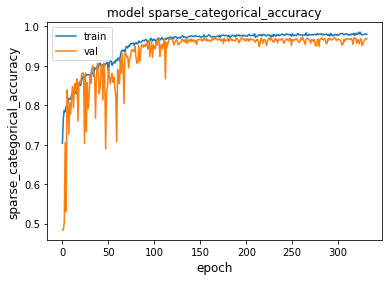

In [15]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

##  Exportieren der besten Hyperparameter
Diese Funktion exportiert die Hyperparameter als JSON Datei wenn die aktuelle Test-Accuracy besser ist als die vorherige

In [16]:
def save():
    hyper_para = {
                "acc" : float(test_acc)
                }
    hyper_para.update(hyper_p)
    path = './'
    file_name = 'hyperparameter'
    write_JSON_file(path, file_name, hyper_para)
    
# wenn best_acc noch nicht definiert ist => importieren von der besten Einstellung sonst 0
try:
    best_acc
except NameError:
    try:
        param = load_JSON("./hyperparameter.json")
        if param:
            best_acc = param["acc"] if "acc" in param else 0
    except FileNotFoundError:
        best_acc = 0

if best_acc < test_acc:
    save()
    print("Die Test Accuracy: {} ist besser als die vorherige Accuracy: {}. Die Datei wurde gespeichtert.".format(test_acc, best_acc))
    best_acc = test_acc
else:
    print("Die aktuellen Tests waren nicht besser als der vorherige beste Run. Aktuell:{}, Beste:{}".format(test_acc, best_acc))

Die Test Accuracy: 0.9696969985961914 ist besser als die vorherige Accuracy: 0.9371212124824524. Die Datei wurde gespeichtert.
